<a href="https://www.kaggle.com/code/hasyimabdillah/testing-workout-model?scriptVersionId=135485899" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import os
import cv2
import time
import random
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [4]:
version = '94'
# main_path = f'/kaggle/input/workout-classification-inceptionv3'
main_path = f'/kaggle/input/workout-model-collection/version {version}'

# tflite
for file in os.listdir(main_path):
    if file.endswith('.tflite'):
        model_file_path = os.path.join(main_path, file)
        print(model_file_path)
        
# h5
for file in os.listdir(main_path):
    if file.endswith('.h5'):
        workout_model = load_model(os.path.join(main_path, file))
        print(os.path.join(main_path, file))

/kaggle/input/workout-model-collection/version 94/workout_model_2023-06-18 09_13_39.495369.tflite
/kaggle/input/workout-model-collection/version 94/workout_model_2023-06-18 09_13_39.495369.h5


In [5]:
interpreter = tf.lite.Interpreter(model_path = model_file_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [74]:
random_classes_names = random.choice(os.listdir('../input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'../input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}\n')

# Construct the input video file path
input_video_file_path = f'../input/workoutfitness-video/{random_classes_names}/{random_file}'

# import label from txt file
labels = []
with open(f'{main_path}/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
        

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
# writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (input_details[0]['shape'][1], input_details[0]['shape'][2])

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

scan_count = 0
# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    print(f'{n}, {text}\t{results[i]}')
    scan_count += 1
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {random_file}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')
print(f'Scan speed: {(end_time - start_time)/scan_count} per frame\n')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

leg extension/leg extension_23.mp4

Duration: 5.9
FPS: 30.0
Total frame: 177.0

Prediction process
1, leg extension
	1.0
16, leg extension
	1.0
31, leg extension
	0.9999982714653015
46, leg extension
	0.9999986886978149
61, leg extension
	0.999998927116394

Actual video: leg extension_23.mp4
Prediction: leg extension

confidence: 0.999998927116394
Prediction time: 1.3630595207214355 sec
Scan speed: 0.2726119041442871 per frame



,exercise,percentage
0,leg extension,9.999989e-01
1,hammer curl,4.644865e-07
2,leg raises,3.504502e-07
3,tricep pushdown,1.483500e-07
4,tricep dips,4.373701e-08
5,t bar row,1.695521e-08
6,hip thrust,1.416946e-08
7,chest fly machine,7.660869e-09
8,deadlift,6.626666e-09
9,pull up,3.889560e-09


# Confussion Matrix

In [7]:
DATA_DIR = '/kaggle/input/workoutexercises-images'

count = 0

for root_dir, cur_dir, files in os.walk('/kaggle/input/workoutexercises-images'):
    count += len(files)

val_split = 0.2
batch = int(val_split*count)
    
ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                 labels='inferred',
                                                 label_mode='categorical',
                                                 image_size=img_size,
                                                 shuffle=True,
                                                 subset='validation',
                                                 validation_split=val_split,
                                                 batch_size=batch,
                                                 seed=1
                                                )

#define labels for testing
for images, test_labels in ds.take(1):  # only take first element of dataset
#     numpy_images = images.numpy()
    y_labels = test_labels.numpy()

y_labels = np.argmax(y_labels, axis=1)

#make prediction
y_preds = np.argmax(workout_model.predict(ds), axis=1)

#get classification report
print(classification_report(y_labels, y_preds, target_names=labels))

Found 13853 files belonging to 22 classes.
Using 2770 files for validation.
1/1 [==============================] - 203s 203s/step
                      precision    recall  f1-score   support

barbell biceps curl
       0.05      0.05      0.05       146
        bench press
       0.05      0.05      0.05       133
  chest fly machine
       0.04      0.04      0.04        98
           deadlift
       0.05      0.05      0.05       103
decline bench press
       0.06      0.06      0.06       102
        hammer curl
       0.05      0.05      0.05       114
         hip thrust
       0.02      0.02      0.02       102
incline bench press
       0.06      0.06      0.06       131
       lat pulldown
       0.05      0.05      0.05       135
     lateral raises
       0.07      0.07      0.07       170
      leg extension
       0.04      0.04      0.04       111
         leg raises
       0.07      0.07      0.07       112
              plank
       0.06      0.06      0.06       210
 

In [8]:
workout_model.evaluate(ds)

1/1 [==============================] - 161s 161s/step - loss: 0.0600 - accuracy: 0.9848


[0.06003301590681076, 0.984837532043457]

In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (20,12))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

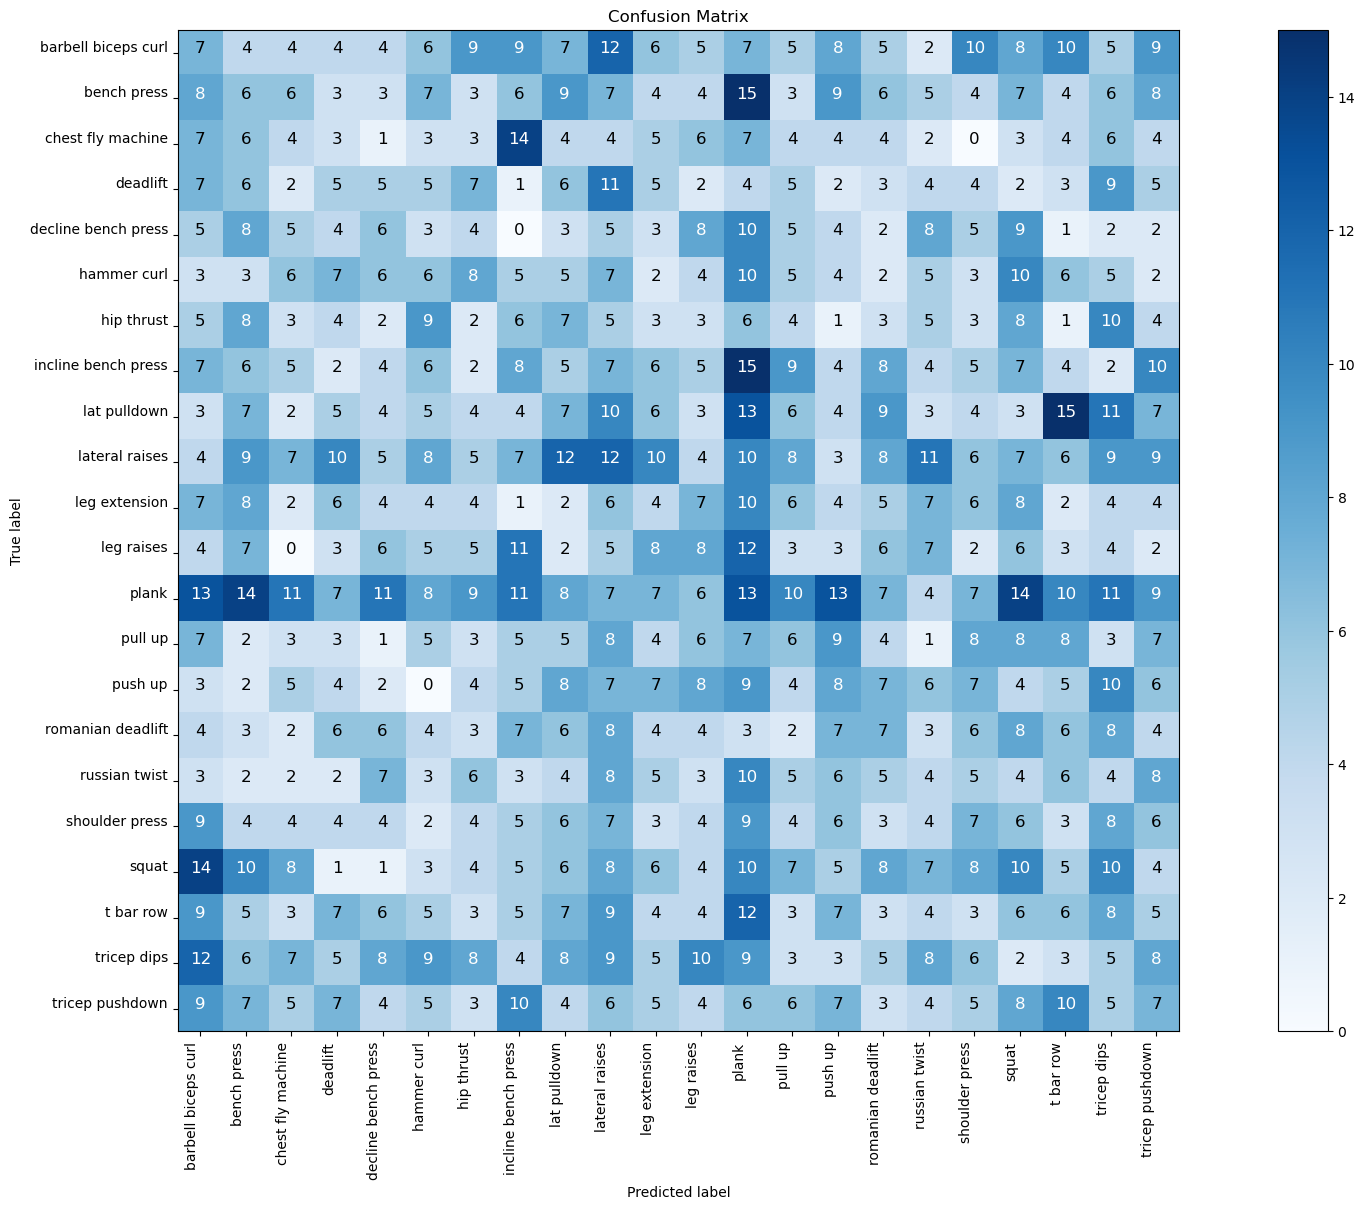

In [10]:
#get confusion matrix
cm = confusion_matrix(y_labels, y_preds)
# print(cm)

#plot
plot_confusion_matrix(cm, labels, normalize=False)

In [11]:
print(f'F1 score for version {version}\n')

#F1 score
print('Macro: ', f1_score(y_labels, y_preds, average='macro'))
print('Micro: ', f1_score(y_labels, y_preds, average='micro'))
print('Weighted: ', f1_score(y_labels, y_preds, average='weighted'))
print('\nNone: ', f1_score(y_labels, y_preds, average=None))

F1 score for version 94

Macro:  0.05254845602792153
Micro:  0.053429602888086646
Weighted:  0.05344516148856001

None:  [0.0472973  0.04511278 0.04123711 0.04878049 0.05940594 0.05333333
 0.0195122  0.0608365  0.05263158 0.07100592 0.03587444 0.07142857
 0.06235012 0.05309735 0.0661157  0.0625     0.03755869 0.0619469
 0.06849315 0.04897959 0.03472222 0.05384615]
